# Creation of Multiple Models
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the mel and shifted mel to train n neural networks.

To try the pitch shifter, just run the first cell and the last cell.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *
%aimport PitchShifterModule
from PitchShifterModule import *

In [7]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [3]:
n_ffts = 2048
n_mels = 256
n_mfcc = 40

In [4]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training
data_label_pairs_flat, data_label_pairs_dict = create_data_label_pairs(n_pitches)

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

The first cell involves 3d arrays, while the second cell involves flattened arrays.

In [14]:
# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list. n_windows is 115 with 75% overlap.
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 1025, 29) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 256, 29) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 40, 29)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, overlap=.5, plot=False) 
                              for waveform in all_wav_data ])

all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

n_files, _, n_windows = all_mfcc.shape

print("all_wav_data shape = " , all_wav_data.shape)
print("all_spectrograms shape = ", all_spectrograms.shape)
print("all_mels shape = ", all_mels.shape)
print("all_mfcc shape = ", all_mfcc.shape)

all_wav_data shape =  (576,)
all_spectrograms shape =  (576, 1025, 29)
all_mels shape =  (576, 256, 29)
all_mfcc shape =  (576, 40, 29)


### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.


In [15]:
# Flatten data

# Create data accessor for flat arrays
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# Create flat mel spectra 
# flat_mels: (16704, 256)
flat_mels_prenorm = np.array([ all_mels[wav_file_idx][:, window_idx] 
                               for wav_file_idx in range(n_files) 
                               for window_idx in range(n_windows) ])

# Globally normalize to [-1, 1]
flat_mels_logged = np.log(flat_mels_prenorm)
max_mels = np.max(np.abs(flat_mels_logged))
flat_mels = flat_mels_logged / max_mels

print(flat_mels.shape)


(16704, 256)


Visualization in plot

Text(0.5, 1.0, 'Restored MFCC: (16704, 256)')

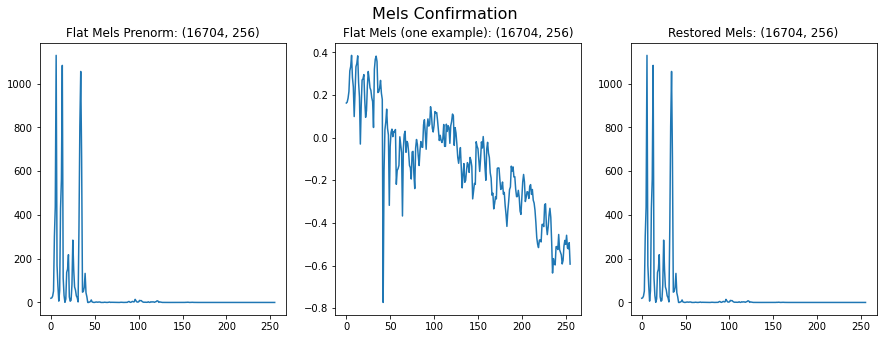

<Figure size 432x288 with 0 Axes>

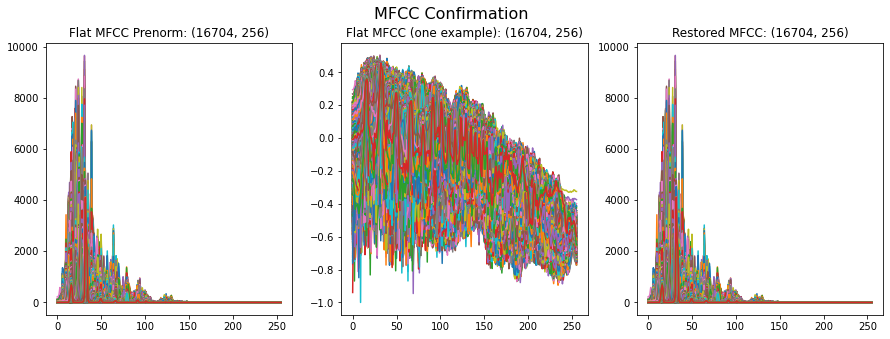

<Figure size 432x288 with 0 Axes>

In [17]:
# Visualize and verify Mels
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("Mels Confirmation", fontsize=16)
ax[0].plot(flat_mels_prenorm[0])
ax[0].set_title("Flat Mels Prenorm: {}".format(flat_mels_prenorm.shape))
ax[1].plot(flat_mels[0])
ax[1].set_title("Flat Mels (one example): {}".format(flat_mels.shape))
ax[2].plot(np.e ** (flat_mels[0] * max_mels))
ax[2].set_title("Restored Mels: {}".format(flat_mels.shape))

# Visualize and verify MFCC
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("MFCC Confirmation", fontsize=16)
ax[0].plot(flat_mels_prenorm.T)
ax[0].set_title("Flat MFCC Prenorm: {}".format(flat_mels_prenorm.shape))
ax[1].plot(flat_mels.T)
ax[1].set_title("Flat MFCC (one example): {}".format(flat_mels.shape))
ax[2].plot(np.e ** (flat_mels.T * max_mels))
ax[2].set_title("Restored MFCC: {}".format(flat_mels.shape))

## Pre-Training - Autoencoder stage

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from timbre features on mfcc and mel spectrums. `labels` are abs(fft) spectrograms. At this stage, pre-training, we simply want to make the NN learn to output fourier spectra.

Note that mel_spectra/mfcc of abs(fft) are equivalent to those of fft itself.

In [18]:
# Create labels

# data:   (16704, 296) (n_wavs * n_windows, n_mfcc + n_mels)
# labels: (16704, 256) (n_wavs * n_windows, flat_mels / 2 + 1)
data = np.concatenate((flat_mels, flat_mels), axis=1)
labels = flat_mels
print(data.shape, labels.shape)

(16704, 512) (16704, 256)


Test-Train split: 1 person from each wav will be the test data

In [19]:
# X_train, Y_train: (11136, 296) (11136, 256) 
# X_val, Y_val:     (5568, 296)  (5568, 256)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_train, Y_train, X_val, Y_val))

# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

torch.Size([11136, 512]) torch.Size([5568, 512]) torch.Size([11136, 256]) torch.Size([5568, 256])


Normalize `labels_prenorm` to range [-1,1]

## Training Procedure (decoder style, no pitch shift)

This takes mel + mel spectrum, and tries to recreate the original FFT.

In [26]:
n_input = 512; n_hid = 512;
# n_ffts = 1025;
lr = 1e-3; n_epochs = 5000; batch_size=11136;
loss_fn = nn.MSELoss()


In [27]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


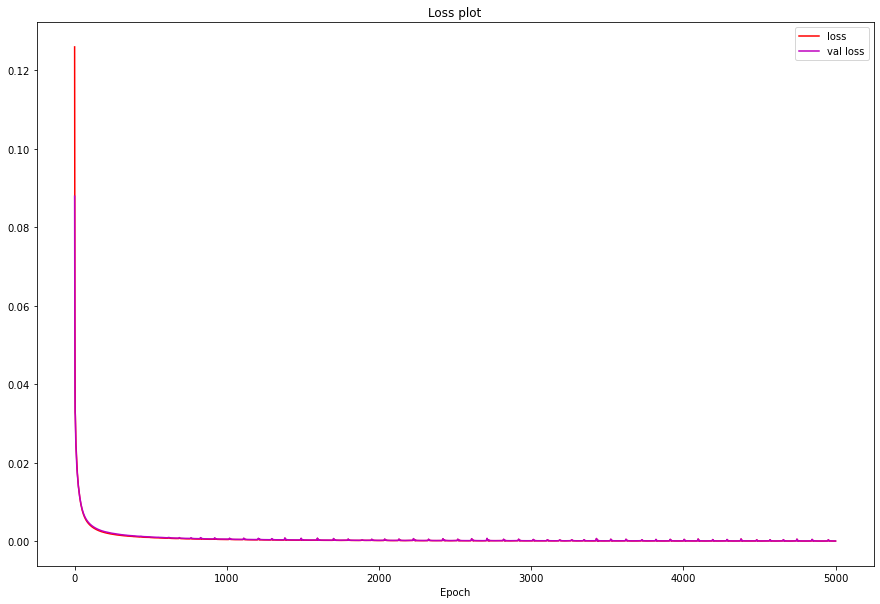

Training Loss before/after: 0.12598079442977905, 8.17686304799281e-05
Validation Loss before/after: 0.08793323487043381, 0.00010710652713896707
Final loss for n_hid[512]: 8.17686304799281e-05
Time taken: 51.00263285636902
[[512, 8.17686304799281e-05, 0.00010710652713896707]]


In [31]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# n_hids = [ 256, 300, 350, 400, 450, 512 ] # - best result was 512.
n_hids = [512]; 
results = [];
for n_hid in n_hids:

    # Training model 
    model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_mels=n_mels)

    # Move the network to GPU (if possible)
    model.to(device)

    # Define optimizer 
    # opt = optim.SGD(model.parameters(), lr=lr)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Fit the model
    tic = time.time()
    train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                            loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
    toc = time.time()
    print('Final loss for n_hid[{}]: {}\nTime taken: {}'.format(n_hid, train_loss, toc - tic))
    results.append([n_hid, train_loss, val_loss])
    
print(results)

Saving the model

In [32]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
model_path = os.path.join("model_data", "VPMModel", "Identity-2Mels-to-Mels_epoch{}_{}_{}_{}.pt"
                          .format(n_epochs, n_input, n_hid, n_mels))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\Identity-2Mels-to-Mels_epoch5000_512_512_256.pt


Loading the saved model, and using the model for prediction example

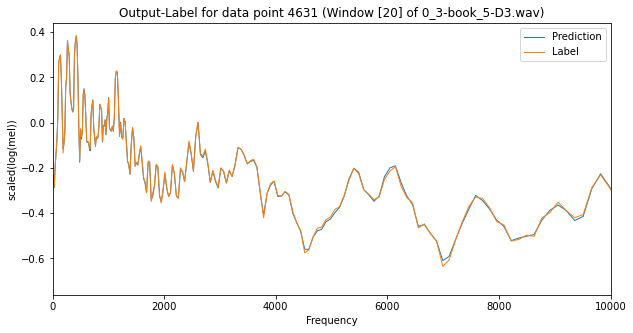

In [33]:
vidx = 3; pIdx = 5; pid = 0; winIdx = 20;
wavIdx = flat_ref_idx(vidx, pIdx, pid)

model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.float(); 
predictions = model(data_tensor).detach().numpy()


# x_axis = librosa.core.fft_frequencies(sample_rate, 1024)
# plt.figure(figsize=(10, 5))
# plt.plot(x_axis, predictions[30000], label='Prediction', linewidth=1)
# plt.plot(x_axis, label_tensor[30000], label='Label', linewidth=1)
# plt.xlim(0, 5000)
# plt.xlabel('Frequency')
# plt.ylabel('abs(fft)')
# plt.legend(loc='best')
# title = "lr" + str(lr) + " n_epochs" + str(n_epochs) + " n_mfcc" + str(n_mfcc) + " n_mels" + str(n_mels) + " n_hid" + str(n_hid) + " n_ffts" + str(n_ffts) + " train_loss" + str(train_loss)
# plt.title("TimbreFNN_mels-fft " + title)

# plt.savefig(model_path + '.png')


# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Graphing of a single mel spectra for one datapoint  #
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
data_point = flat_data_idx(wavIdx, winIdx)
x_axis = librosa.core.mel_frequencies(n_mels=256, fmin=0.0, fmax=22050.0)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions[data_point], label='Prediction', linewidth=1)
plt.plot(x_axis, label_tensor[data_point], label='Label', linewidth=1)
plt.xlim(0, 10000)
plt.xlabel('Frequency')
plt.ylabel('scaled(log(mel))')
plt.legend(loc='best')
plt.title("Output-Label for data point {} (Window [{}] of {})".format(data_point, winIdx, flat_data_ref_list[wavIdx]))
title = "TimbreFNN_mels-mels "+ "lr" + str(lr) + " n_epochs" + str(n_epochs) + " n_mfcc" + str(n_mfcc) + " n_mels" + str(n_mels) + " n_hid" + str(n_hid) + " n_ffts" + str(n_ffts) + " train_loss" + str(train_loss)
# plt.title("TimbreFNN_mels-mels " + title)

plt.savefig(model_path + '.png')

## Training - Waveform conformation for each individual pitch

### Data-Label Structuring Function
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from mel spectrums. `labels` are mel spectrograms. At this stage, we want the ANN to learn to conform pitch shifted mel spectra to the correct form.

In [37]:
def create_training_dataset(n_ffts, overlap, n_mels,
                            shift_amt, sparsity_factor = 8):
    print('Creating dataset for shift_amt = {}'.format(shift_amt))
    
    # Initialize shift_amt dependent data structures
    pairs = data_label_pairs_dict[shift_amt]
    # all_pitched_spectra: (576, 1025, 29)
    _, all_pitched_spectra = resample_pitch_shift(all_wav_data, shift_amt, overlap, n_ffts=n_ffts)
    # all_mels: (576, 256, 29)
    all_pitched_mels_prenorm = np.array([ ffts_to_mel(ffts, n_mels = n_mels, skip_mfcc=True) 
                                          for ffts in all_pitched_spectra ])
    all_pitched_mels_prenorm_logged = np.log(all_pitched_mels_prenorm)
    max_pitched_mels = np.max(np.abs(all_pitched_mels_prenorm_logged))
    all_pitched_mels = all_pitched_mels_prenorm_logged / max_pitched_mels

    X_train = []; X_val = []; Y_train = []; Y_val = [];
    list_of_test_idx = []
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # If the pair is valid (does not go out of range), then proceed.
            if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:
                # Choose the person for this pitch/vowel to be used as test data.
                test_pid = int(np.random.rand() * 3)

                for pid_idx in range(n_people):
                    # Wav index
                    wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                    wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)
                    # Window index lower-upper bounds
                    data_flat_start_idx = flat_data_idx(wav_idx, 0)
                    data_flat_end_idx = flat_data_idx(wav_idx + 1, 0)
                    label_flat_start_idx = flat_data_idx(wav_idx_shifted, 0)
                    label_flat_end_idx = flat_data_idx(wav_idx_shifted + 1, 0)
                    # Get the x(n_datapoints, n_mels + n_mels), y(n_datapoints, n_mels)
                    x_item = np.hstack((flat_mels[data_flat_start_idx:data_flat_end_idx], 
                                        all_pitched_mels[wav_idx].T))[0::sparsity_factor]
                    y_item = flat_mels[label_flat_start_idx:label_flat_end_idx][0::sparsity_factor]
                        
                    if (pid_idx != test_pid):
                        X_train.extend(x_item)
                        Y_train.extend(y_item)
                    else:
                        X_val.extend(x_item)
                        Y_val.extend(y_item)
                        list_of_test_idx.append((wav_idx,wav_idx_shifted))
                        
    X_train = np.array(X_train); Y_train = np.array(Y_train);
    X_val = np.array(X_val); Y_val = np.array(Y_val);
    print("X_train: {}, Y_train: {}, X_val: {}, Y_val: {}".format(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape))

    list_of_test_idx = np.array(list_of_test_idx)
    return X_train, Y_train, X_val, Y_val, list_of_test_idx, max_pitched_mels, all_pitched_mels

## Training Pitch-shift specific models
Train 11 different NNs - one for each pitch shift.

0. Shift amt -5
Creating dataset for shift_amt = -5
X_train: (2112, 512), Y_train: (2112, 256), X_val: (1056, 512), Y_val: (1056, 256)
(2112, 512) (2112, 256) (1056, 512) (1056, 256)


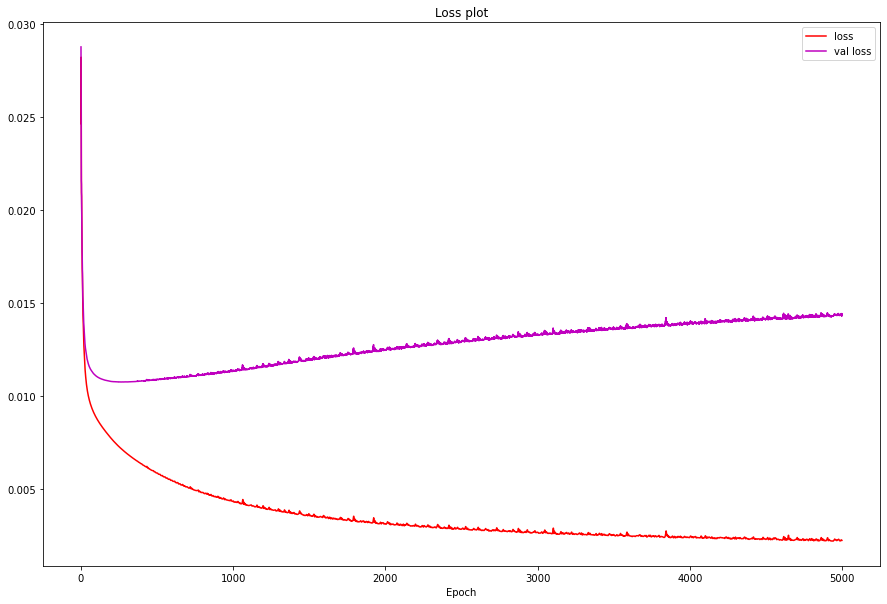

Training Loss before/after: 0.024658260866999626, 0.002257560845464468
Validation Loss before/after: 0.028781650587916374, 0.01442915853112936
Final loss: 0.002257560845464468
Time taken: 26.12972402572632
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[0,-5]-2Mels-to-Mels_epoch5000_512_512_256.pt
1. Shift amt -4
Creating dataset for shift_amt = -4
X_train: (2304, 512), Y_train: (2304, 256), X_val: (1152, 512), Y_val: (1152, 256)
(2304, 512) (2304, 256) (1152, 512) (1152, 256)


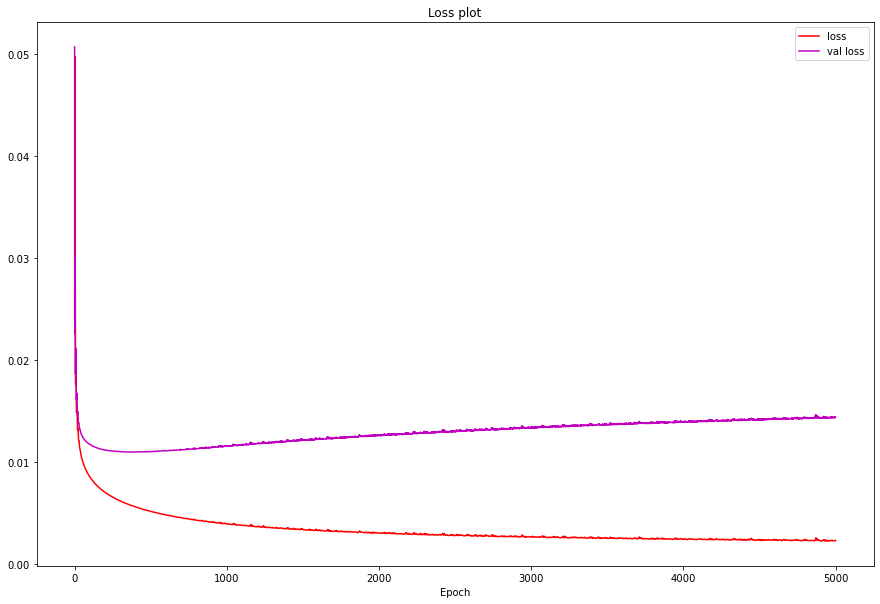

Training Loss before/after: 0.024119878187775612, 0.0023641474545001984
Validation Loss before/after: 0.05073695629835129, 0.014443708583712578
Final loss: 0.0023641474545001984
Time taken: 24.18985629081726
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[1,-4]-2Mels-to-Mels_epoch5000_512_512_256.pt
2. Shift amt -3
Creating dataset for shift_amt = -3
X_train: (2496, 512), Y_train: (2496, 256), X_val: (1248, 512), Y_val: (1248, 256)
(2496, 512) (2496, 256) (1248, 512) (1248, 256)


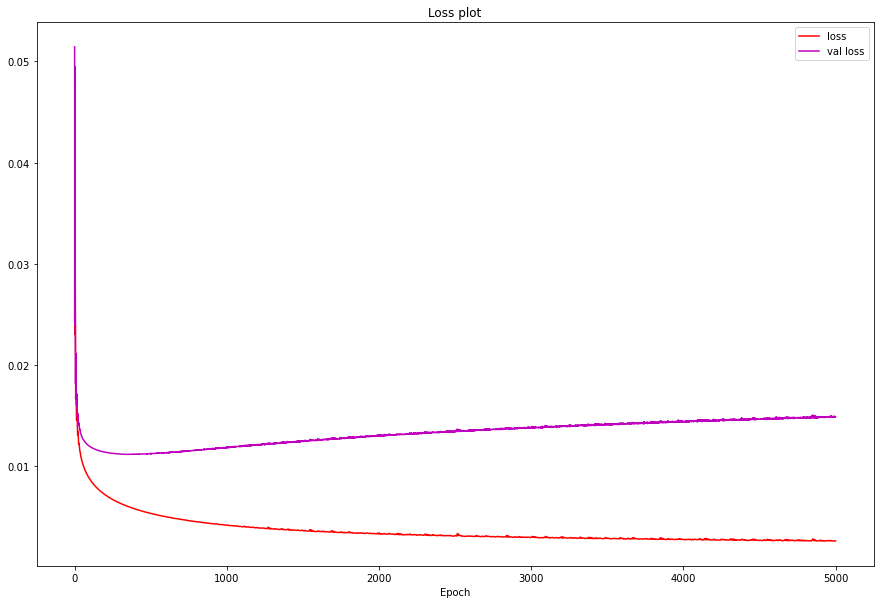

Training Loss before/after: 0.02432462014257908, 0.002576440339908004
Validation Loss before/after: 0.051438216120004654, 0.014861051924526691
Final loss: 0.002576440339908004
Time taken: 22.525519371032715
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[2,-3]-2Mels-to-Mels_epoch5000_512_512_256.pt
3. Shift amt -2
Creating dataset for shift_amt = -2
X_train: (2688, 512), Y_train: (2688, 256), X_val: (1344, 512), Y_val: (1344, 256)
(2688, 512) (2688, 256) (1344, 512) (1344, 256)


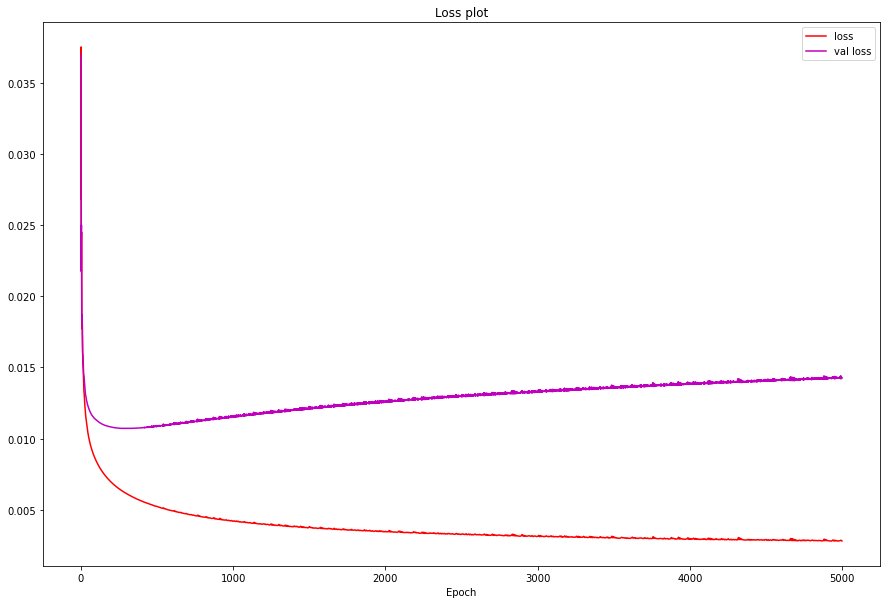

Training Loss before/after: 0.026809778064489365, 0.002817594911903143
Validation Loss before/after: 0.03693646937608719, 0.014269644394516945
Final loss: 0.002817594911903143
Time taken: 23.449727058410645
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[3,-2]-2Mels-to-Mels_epoch5000_512_512_256.pt
4. Shift amt -1
Creating dataset for shift_amt = -1
X_train: (2880, 512), Y_train: (2880, 256), X_val: (1440, 512), Y_val: (1440, 256)
(2880, 512) (2880, 256) (1440, 512) (1440, 256)


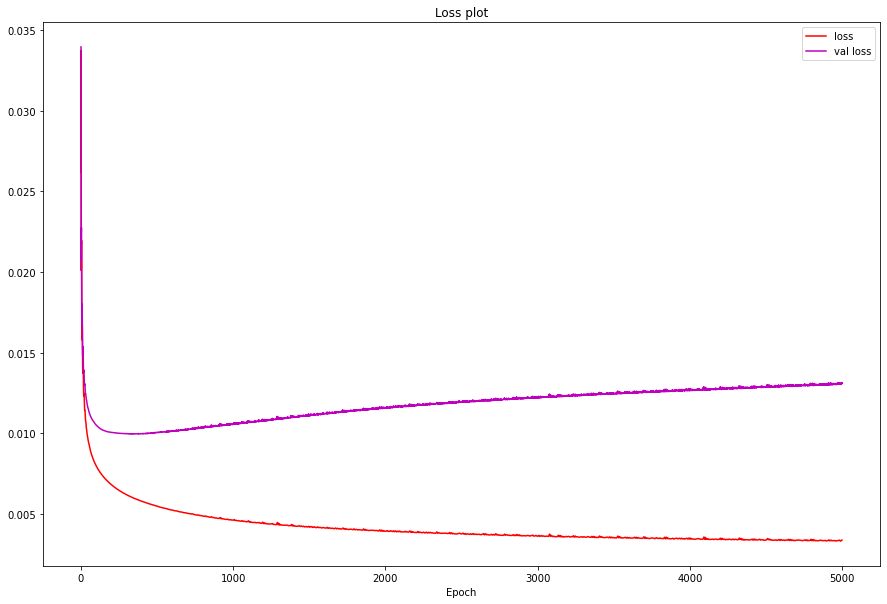

Training Loss before/after: 0.02619686722755432, 0.0033700293861329556
Validation Loss before/after: 0.03395115211606026, 0.013127395883202553
Final loss: 0.0033700293861329556
Time taken: 22.705377340316772
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[4,-1]-2Mels-to-Mels_epoch5000_512_512_256.pt
5. Shift amt 0
Creating dataset for shift_amt = 0
X_train: (3072, 512), Y_train: (3072, 256), X_val: (1536, 512), Y_val: (1536, 256)
(3072, 512) (3072, 256) (1536, 512) (1536, 256)


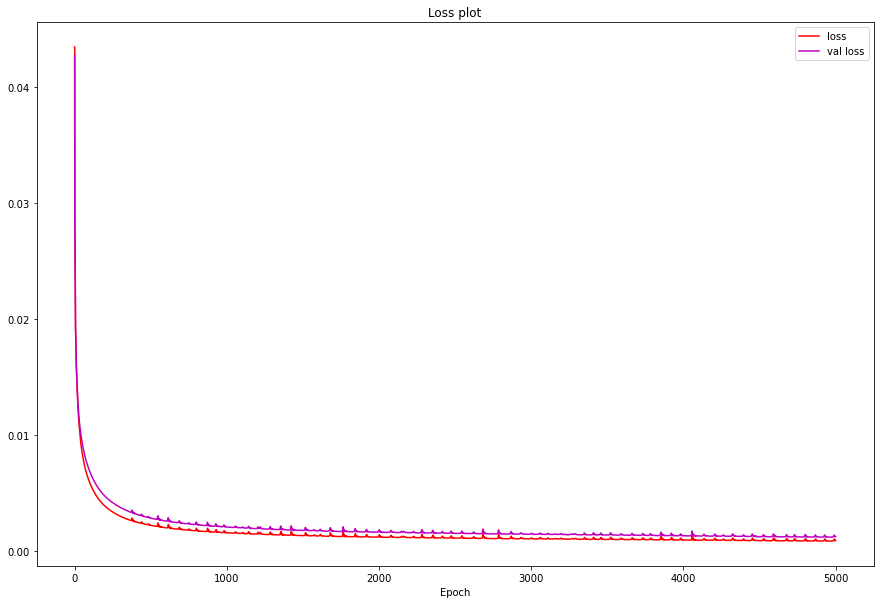

Training Loss before/after: 0.04343370720744133, 0.0009297700598835945
Validation Loss before/after: 0.04266096279025078, 0.0012674162862822413
Final loss: 0.0009297700598835945
Time taken: 22.560604333877563
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[5,0]-2Mels-to-Mels_epoch5000_512_512_256.pt
6. Shift amt 1
Creating dataset for shift_amt = 1
X_train: (2880, 512), Y_train: (2880, 256), X_val: (1440, 512), Y_val: (1440, 256)
(2880, 512) (2880, 256) (1440, 512) (1440, 256)


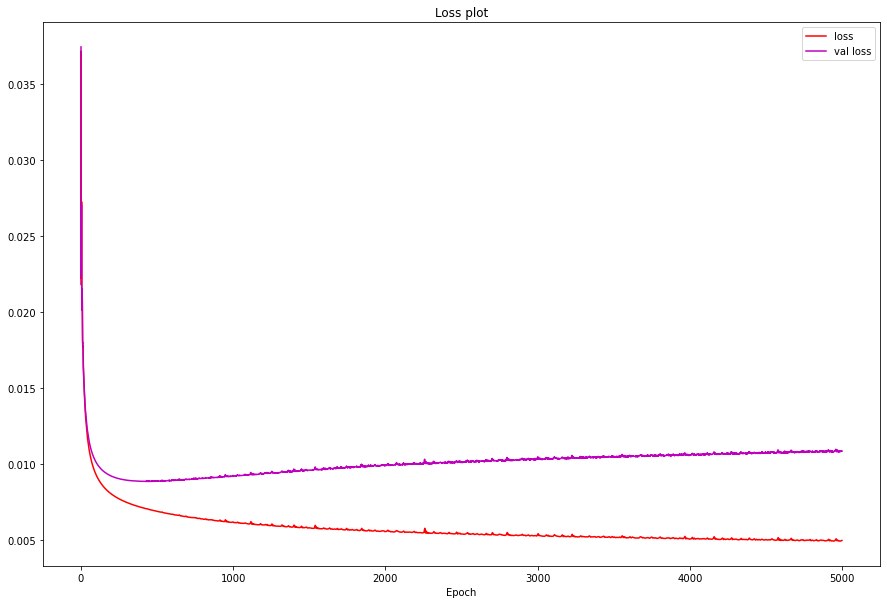

Training Loss before/after: 0.021818537265062332, 0.004985278472304344
Validation Loss before/after: 0.03743918985128403, 0.010861838236451149
Final loss: 0.004985278472304344
Time taken: 20.80191707611084
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[6,1]-2Mels-to-Mels_epoch5000_512_512_256.pt
7. Shift amt 2
Creating dataset for shift_amt = 2
X_train: (2688, 512), Y_train: (2688, 256), X_val: (1344, 512), Y_val: (1344, 256)
(2688, 512) (2688, 256) (1344, 512) (1344, 256)


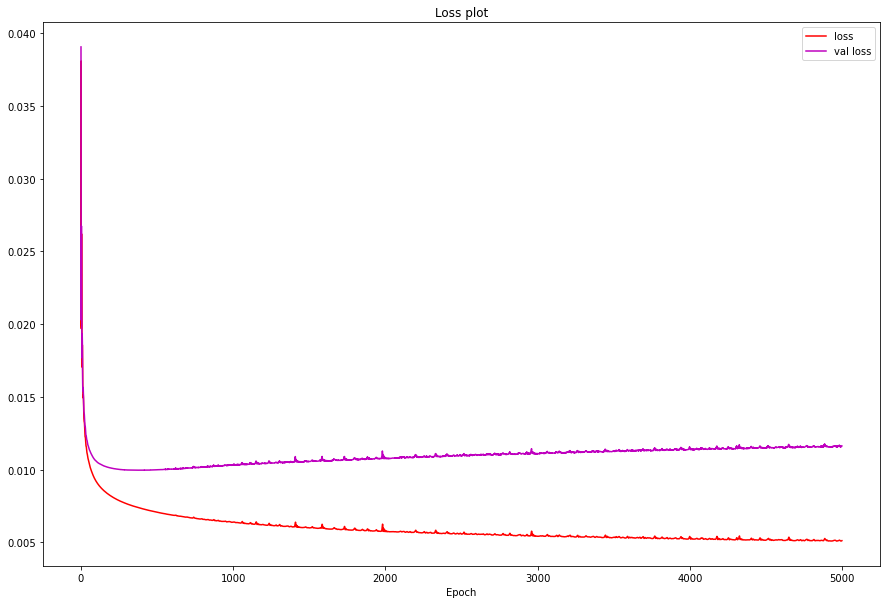

Training Loss before/after: 0.019918913021683693, 0.0051195211708545685
Validation Loss before/after: 0.03905080258846283, 0.011628090403974056
Final loss: 0.0051195211708545685
Time taken: 22.982784271240234
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[7,2]-2Mels-to-Mels_epoch5000_512_512_256.pt
8. Shift amt 3
Creating dataset for shift_amt = 3
X_train: (2496, 512), Y_train: (2496, 256), X_val: (1248, 512), Y_val: (1248, 256)
(2496, 512) (2496, 256) (1248, 512) (1248, 256)


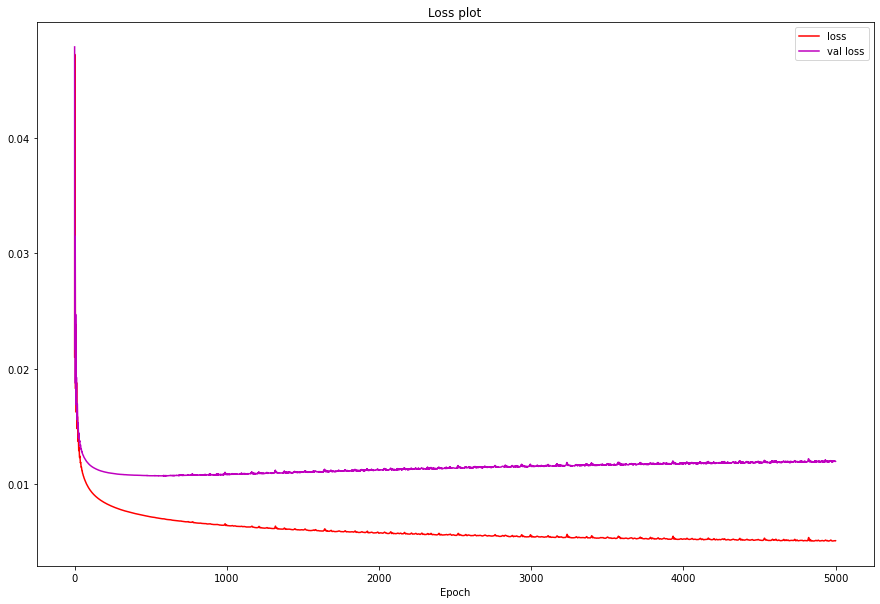

Training Loss before/after: 0.021027332171797752, 0.005132270976901054
Validation Loss before/after: 0.04784546047449112, 0.01199992187321186
Final loss: 0.005132270976901054
Time taken: 19.84883737564087
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[8,3]-2Mels-to-Mels_epoch5000_512_512_256.pt
9. Shift amt 4
Creating dataset for shift_amt = 4
X_train: (2304, 512), Y_train: (2304, 256), X_val: (1152, 512), Y_val: (1152, 256)
(2304, 512) (2304, 256) (1152, 512) (1152, 256)


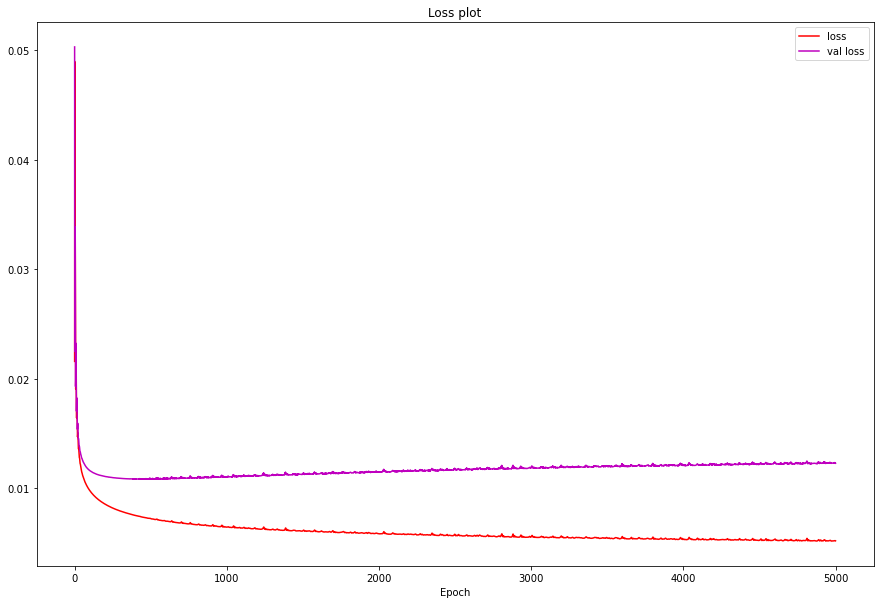

Training Loss before/after: 0.021596424281597137, 0.005202291999012232
Validation Loss before/after: 0.05032035708427429, 0.012291939929127693
Final loss: 0.005202291999012232
Time taken: 20.581316709518433
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[9,4]-2Mels-to-Mels_epoch5000_512_512_256.pt
10. Shift amt 5
Creating dataset for shift_amt = 5
X_train: (2112, 512), Y_train: (2112, 256), X_val: (1056, 512), Y_val: (1056, 256)
(2112, 512) (2112, 256) (1056, 512) (1056, 256)


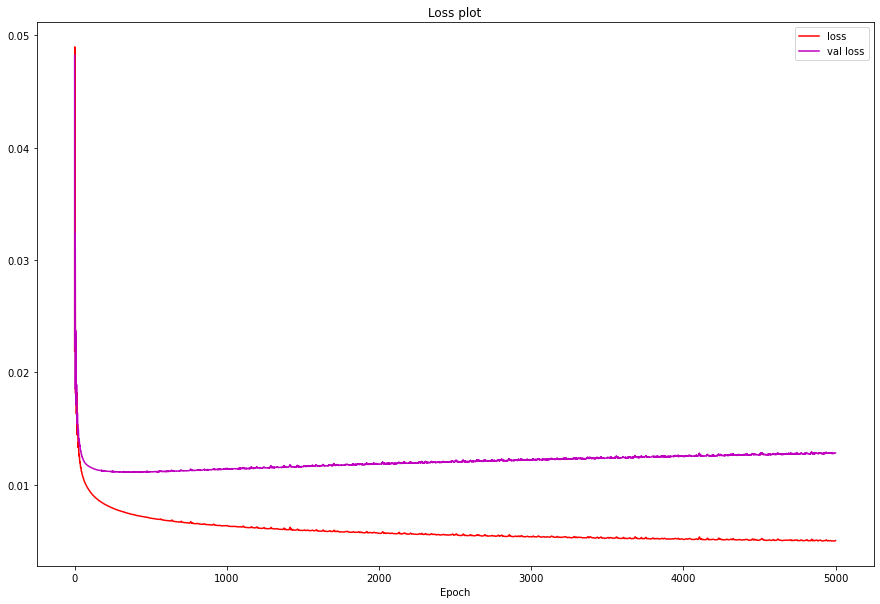

Training Loss before/after: 0.021890081465244293, 0.005008902866393328
Validation Loss before/after: 0.04822683334350586, 0.012816214933991432
Final loss: 0.005008902866393328
Time taken: 20.462762594223022
Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\VPMModel\[10,5]-2Mels-to-Mels_epoch5000_512_512_256.pt


In [38]:
# n_ffts = 2048; overlap = 0.5;
# n_input = 262; n_hid = 262; n_output = 256; 
# n_mels = 256; n_mfcc = 12; n_timb_hid = 10; n_timb = 6

overlap = 0.5;
n_input = 2 * n_mels; n_hid = 512; n_mels = 256;
lr = 1e-3; n_epochs = 5000; batch_size=None;
max_mels;
# Transfer learning - we take the model from the autoencoder stage
model_path = os.path.join("model_data", "VPMModel", "Identity-2Mels-to-Mels_epoch5000_512_512_256.pt")
# Define loss 
loss_fn = nn.MSELoss()

pitch_shift_amts = [ -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
nn_paths = []
max_values = []
with open(os.path.join("model_data", "VPMModel", "ModelInfo.txt"), 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the headers
    writer.writerow(["Index", "Pitch Shift Amt", "Max Mels", "Path"])
    
    for idx, pitch_shift_amt in enumerate(pitch_shift_amts):
        print("{}. Shift amt {}".format(idx, pitch_shift_amt))
        X_train, Y_train, X_val, Y_val, list_of_test_idx, max_pitched_mels, all_pitched_mels = create_training_dataset(n_ffts, overlap, n_mels, pitch_shift_amt, sparsity_factor = 4)
        print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape) 
        X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_train, Y_train, X_val, Y_val))
        X_train.float(); Y_train.float(); X_val.float(); Y_val.float();

        model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_mels=n_mels)
        model.load_state_dict(torch.load(model_path))
        model.eval()

         # Use GPU if possible (will run on CPU otherwise)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # Move inputs to GPU (if possible)
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)

        # Move the network to GPU (if possible)
        model.to(device) 
        # Define optimizer 
        # opt = optim.SGD(model.parameters(), lr=lr)
        opt = optim.Adam(model.parameters(), lr=lr)

        # Fit the model
        tic = time.time()
        train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                                loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
        toc = time.time()
        print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))    

        n_output = n_mels
        print("Model's state_dict:")
        for param_tensor in model.state_dict():
            print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        currModelPath = "[{} {}]-2Mels-to-Mels_epoch{}_{}_{}_{}.pt".format(idx, pitch_shift_amt, n_epochs, n_input, n_hid, n_mels)
        model_path = os.path.join("model_data", "VPMModel", currModelPath)
        torch.save(model.state_dict(), model_path)
        print("Model saved at {}".format(model_path))    
              
        max_values.append(max_pitched_mels)
        nn_paths.append(model_path)
        writer.writerow([idx, pitch_shift_amt, max_pitched_mels, currModelPath])

    # Close csv writer
    f.close()


# Generate many example files
This is how you use the pitch shifter.

In [3]:
# Example of doing a batch
# pIdx = 6; pid = 0;
# vIdxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# shiftAmts = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

pIdx = 5; pid = 0;
vIdxs = [5]
shiftAmts = [4]

for vIdx in vIdxs:
    for shiftAmt in shiftAmts:
#         wavIdx = flat_ref_idx(vIdx, pIdx, pid)
#         filename = [ flat_data_ref_list[wavIdx] ]
#         wavform = load_wav_files(os.path.join("Data", "dataset"), filename)[0]
        
        # Example of loading a specific file
        filename = [ "scale.wav" ]
        wavform = load_wav_files("",filename)[0]
        
        print("Shifting {} by {}".format(filename[0], shiftAmt))
        decodedShift, pureShift = PitchShift(wavform, shiftAmt)
        
        sio.wavfile.write(os.path.join("many_expts", 'Decoded_[{}]_{}.wav'.format(shiftAmt, filename)), 44100, decodedShift)
        sio.wavfile.write(os.path.join("many_expts", 'PureShift_[{}]_{}.wav'.format(shiftAmt, filename)), 44100, pureShift)

Please resample to 44100Hz for better results, but continuing regardless...
Shifting scale.wav by 4
